<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Filter_Rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Filter Rules
---
## Load useful packages...

In [1]:
from my_library import *

14:06:07 Starting...
14:06:07 Installing yfinance into Google notebook...
14:06:18 Installing arch into Google notebook...
14:06:29 Initialized.


## Get S&P 500 Index Data from Yahoo! Finance

In [17]:
nprint("Fetching data from Yahoo!...")
data,sname=download(ticker:='SPY','1990-01-02','2019-12-31',auto_adjust=True,progress=False),'S&P 500 Index ETF'
data.columns=data.columns.get_level_values(0)
data.columns.name=ticker
data.index=pd.PeriodIndex(data.index,freq='B')
data['Return']=data['Close'].pct_change()*hundred
data.dropna(inplace=True)
display(data)

14:16:26 Fetching data from Yahoo!...


<ipython-input-17-eadee26bc247>:5: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  data.index=pd.PeriodIndex(data.index,freq='B')


SPY,Close,High,Low,Open,Volume,Return
Date,,,,,,
1993-02-01,24.626419,24.626419,24.469895,24.469895,480500,0.711161
1993-02-02,24.678600,24.695992,24.556860,24.609034,201300,0.211891
1993-02-03,24.939487,24.956879,24.696006,24.713397,529400,1.057139
1993-02-04,25.043837,25.096011,24.748180,25.026445,531500,0.418409
1993-02-05,25.026451,25.078626,24.887319,25.026451,492100,-0.069420
...,...,...,...,...,...,...
2019-12-23,296.917694,297.315155,296.769796,297.259697,52990000,0.152760
2019-12-24,296.927002,297.195041,296.621953,297.148835,20270000,0.003135
2019-12-26,298.507660,298.516912,297.306024,297.315248,30911200,0.532339


## Fit baseline AR(1) GJR-AGARCH(1,1) model

In [22]:
from arch.univariate import ARX
model = ARX(data['Return'],lags=1)
model.volatility = GARCH2(0,1,1)
model.distribution = GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
display(baseline:=pd.DataFrame([fit.params,fit.std_err]).T)
data['Volatility']=fit.conditional_volatility
data['Alpha']=baseline.loc['Const','params']+baseline.loc['Return[1]','params']*data['Return'].shift()
data['Z Score']=(data['Return']-data['Alpha'])/data['Volatility'].shift()
display(data)
nprint("Baseline IC %.2f %%." % (hundred*fit.rsquared**half))

14:21:48
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8759.18
Distribution:      Generalized Error Distribution   AIC:                           17530.4
Method:                        Maximum Likelihood   BIC:                           17571.3
                                                    No. Observations:                 6777
Date:                            Wed, Mar 26 2025   Df Residuals:                     6775
Time:                                    14:21:48   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
--------------

,params,std_err
Const,0.062286,0.009119
Return[1],-0.037913,0.013200
omega,0.017251,0.003156
gamma[1],0.187389,0.021783
beta[1],0.888963,0.011778
nu,1.348241,0.036888


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score
Date,,,,,,,,,
1993-02-01,24.626419,24.626419,24.469895,24.469895,480500,0.711161,NaN,NaN,NaN
1993-02-02,24.678600,24.695992,24.556860,24.609034,201300,0.211891,0.783965,0.035323,NaN
1993-02-03,24.939487,24.956879,24.696006,24.713397,529400,1.057139,0.750739,0.054252,1.279250
1993-02-04,25.043837,25.096011,24.748180,25.026445,531500,0.418409,0.719916,0.022206,0.527751
1993-02-05,25.026451,25.078626,24.887319,25.026451,492100,-0.069420,0.691363,0.046423,-0.160911
...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917694,297.315155,296.769796,297.259697,52990000,0.152760,0.484166,0.045664,0.216681
2019-12-24,296.927002,297.195041,296.621953,297.148835,20270000,0.003135,0.475015,0.056494,-0.110208
2019-12-26,298.507660,298.516912,297.306024,297.315248,30911200,0.532339,0.467301,0.062167,0.989805


14:21:48 Baseline IC 5.46 %.


## Fit a Basic "Filter Rules" Model

In [177]:
# create filter rules summary holder, re-run this cell to reset dataframe
from itertools import product
summary=pd.DataFrame({tuple(x):[] for x in product(['Active','Inactive'],['Mean','Std.Dev.','Count','Std.Err.','Vol.Ratio'])},index=pd.Series([],name='Filter'))
nprint("Reset summary data frame.")

17:57:15 Reset summary data frame.


17:57:39 Creating filter rule indicators with order 3 and offset 0.100000.
17:57:39 Conditional returns:


SPY,Close,High,Low,Open,Volume,Return,Volatility,Alpha,Z Score,Direction,...,Z_7,Direction_7,Filter_000,Filter_001,Filter_010,Filter_011,Filter_100,Filter_101,Filter_110,Filter_111
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-01,24.626419,24.626419,24.469895,24.469895,480500,0.711161,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-02,24.678600,24.695992,24.556860,24.609034,201300,0.211891,0.783965,0.035323,NaN,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-03,24.939487,24.956879,24.696006,24.713397,529400,1.057139,0.750739,0.054252,1.279250,1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-04,25.043837,25.096011,24.748180,25.026445,531500,0.418409,0.719916,0.022206,0.527751,1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-05,25.026451,25.078626,24.887319,25.026451,492100,-0.069420,0.691363,0.046423,-0.160911,-1.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,296.917694,297.315155,296.769796,297.259697,52990000,0.152760,0.484166,0.045664,0.216681,1.0,...,1.356581,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2019-12-24,296.927002,297.195041,296.621953,297.148835,20270000,0.003135,0.475015,0.056494,-0.110208,-1.0,...,0.052385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2019-12-26,298.507660,298.516912,297.306024,297.315248,30911200,0.532339,0.467301,0.062167,0.989805,1.0,...,1.117893,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Active                                         Inactive            \
             Count      Mean  Std.Dev.  Std.Err. Vol.Ratio    Count      Mean   
Rule                                                                            
Filter_000   590.0  0.206878  1.566589  0.064495  1.186744   6188.0  0.027767   
Filter_00   1356.0  0.113987  1.419231  0.038541  1.170339   5422.0  0.025694   
Filter_101   598.0  0.102463  1.025832  0.041949  0.920462   6180.0  0.037639   
Filter_0    3001.0  0.061619  1.268203  0.023150  1.122737   3777.0  0.028848   
Filter_110   671.0  0.055102  0.928623  0.035849  0.857950   6107.0  0.042067   
Filter_001   643.0  0.052358  1.297108  0.051153  1.138763   6135.0  0.042414   
Filter_10   1418.0  0.044904  1.127285  0.029936  0.960366   5360.0  0.042949   
Filter_011   604.0  0.031708  0.981937  0.039954  1.045908   6174.0  0.044497   
Filter_1    3104.0  0.030092  1.019435  0.018298  0.898822   3674.0  0.054565   
Filter_11   1392.0  0.018365  0.913856  0.024494  0.841487   5386.0  0.049817   
Filter_100   669.0 -0.010813  1.254634  0.048507  1.005960   6109.0  0.049290   
Filter_010   620.0 -0.016511  1.187710  0.047700  1.090429   6158.0  0.049385   
Filter_01   1345.0 -0.006384  1.100697  0.030013  1.071647   5433.0  0.055672   
Filter_111   586.0 -0.031903  0.921586  0.038070  0.802368   6192.0  0.050480   

                                           Z Score  
            Std.Dev.  Std.Err. Vol.Ratio            
Rule                                                
Filter_000  1.092095  0.013883  0.992894  2.714928  
Filter_00   1.061140  0.014411  0.967942  2.145776  
Filter_101  1.152783  0.014664  1.019946  1.458738  
Filter_0    1.031168  0.016779  0.913404  1.146209  
Filter_110  1.163366  0.014887  1.027028  0.335805  
Filter_001  1.124877  0.014361  0.997305  0.187151  
Filter_10   1.146253  0.015657  1.024731  0.057860  
Filter_011  1.156781  0.014722  1.008211 -0.300354  
Filter_1    1.236533  0.020400  1.097762 -0.893028  
Filter_11   1.194159  0.016272  1.051164 -1.069562  
Filter_100  1.129194  0.014447  1.012312 -1.187503  
Filter_010  1.137474  0.014495  1.002943 -1.321797  
Filter_01   1.152046  0.015630  0.995358 -1.833864  
Filter_111  1.160749  0.014751  1.029230 -2.017813

17:57:40 Saved figure to '/content/drive/MyDrive/Subsequent Return Associated with Filter Rules.png'.


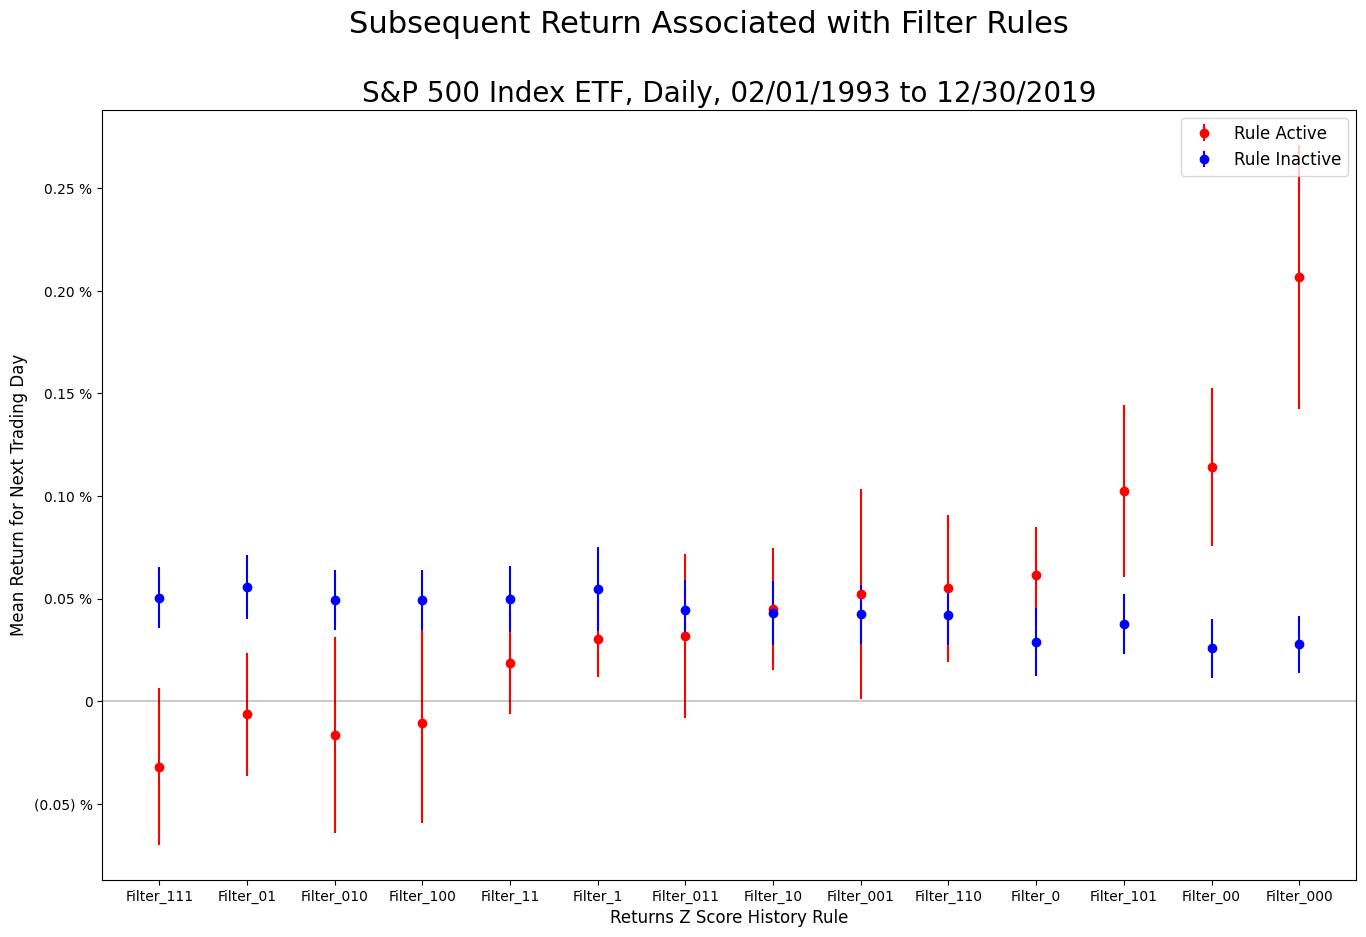

In [180]:
nprint("Creating filter rule indicators with order {:d} and offset {:f}.".format(forder:=3,foffset:=0.1))

data['Direction']=data['Z Score'].apply(lambda x: one if x>foffset else -one if x<-foffset else zero)
data.drop(data.columns[data.columns.str.contains('Filter')],axis=1,inplace=True)

for lag in range(1,forder+1):
    data['Z_'+str(lag)]=data['Z Score'].shift(lag)
    data['Direction_'+str(lag)]=data['Direction'].shift(lag)

for rule in range(2**forder):
    rmap=list(map(lambda x:-one if x=='0' else +one,label:="{:0#b}".replace("#",str(forder)).format(rule)))
    data['Filter_'+label]=(data['Direction_1']==rmap[0])

    for lag in range(2,forder+1):
        data['Filter_'+label]&=(data['Direction_'+str(lag)]==rmap[lag-1])

    data['Filter_'+label]=data['Filter_'+label].apply(lambda x:one if x else zero)

nprint("Conditional returns:")
display(data)

for f in data.columns[data.columns.str.contains('Filter')]:
    summary=summary.copy() # defrag
    g=data[[f,'Return']].groupby(f)
    h=data[[f,'Z Score']].groupby(f)

    for s in 'Active','Inactive':
        summary.loc[f,(s,'Mean')]=g.mean().loc[t:=one if s=='Active' else zero,'Return']
        summary.loc[f,(s,'Std.Dev.')]=g.std().loc[t,'Return']
        summary.loc[f,(s,'Count')]=g.count().loc[t,'Return']
        summary.loc[f,(s,'Vol.Ratio')]=h.std().loc[t,'Z Score']

    for s in [c for c in set(summary.columns.get_level_values(0)) if c!='Z Score']:
        summary.loc[f,(s,'Std.Err.')]=summary.loc[f,(s,'Std.Dev.')]/np.sqrt(summary.loc[f,(s,'Count')])

summary=summary[sorted(summary.columns)].copy()
summary['Z Score']=(summary['Active','Mean']-summary['Inactive','Mean'])/np.sqrt(summary['Active','Std.Err.']**two+summary['Inactive','Std.Err.']**two)
summary.index.name='Rule'
display(summary.sort_values('Z Score',ascending=False))

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=summary.sort_values('Z Score').index,y:=summary.loc[x,('Active','Mean')],ye:=summary.loc[x,('Active','Std.Err.')],fmt='o',color='red',label='Rule Active')
plot.errorbar(x,y:=summary.loc[x,('Inactive','Mean')],ye:=summary.loc[x,('Inactive','Std.Err.')],fmt='o',color='blue',label='Rule Inactive')

if forder>3:
    plot.tick_params(axis='x',labelrotation=90)

plot.set_ylabel('Mean Return for Next Trading Day',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Returns Z Score History Rule',fontsize=12)
plot.axhline(color='black',alpha=0.2)
figure.suptitle(title:='Subsequent Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)
plot.legend(fontsize=12)
figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

17:57:47 Saved figure to '/content/drive/MyDrive/Volatility on Next Day After Filter Rule Triggered.png'.


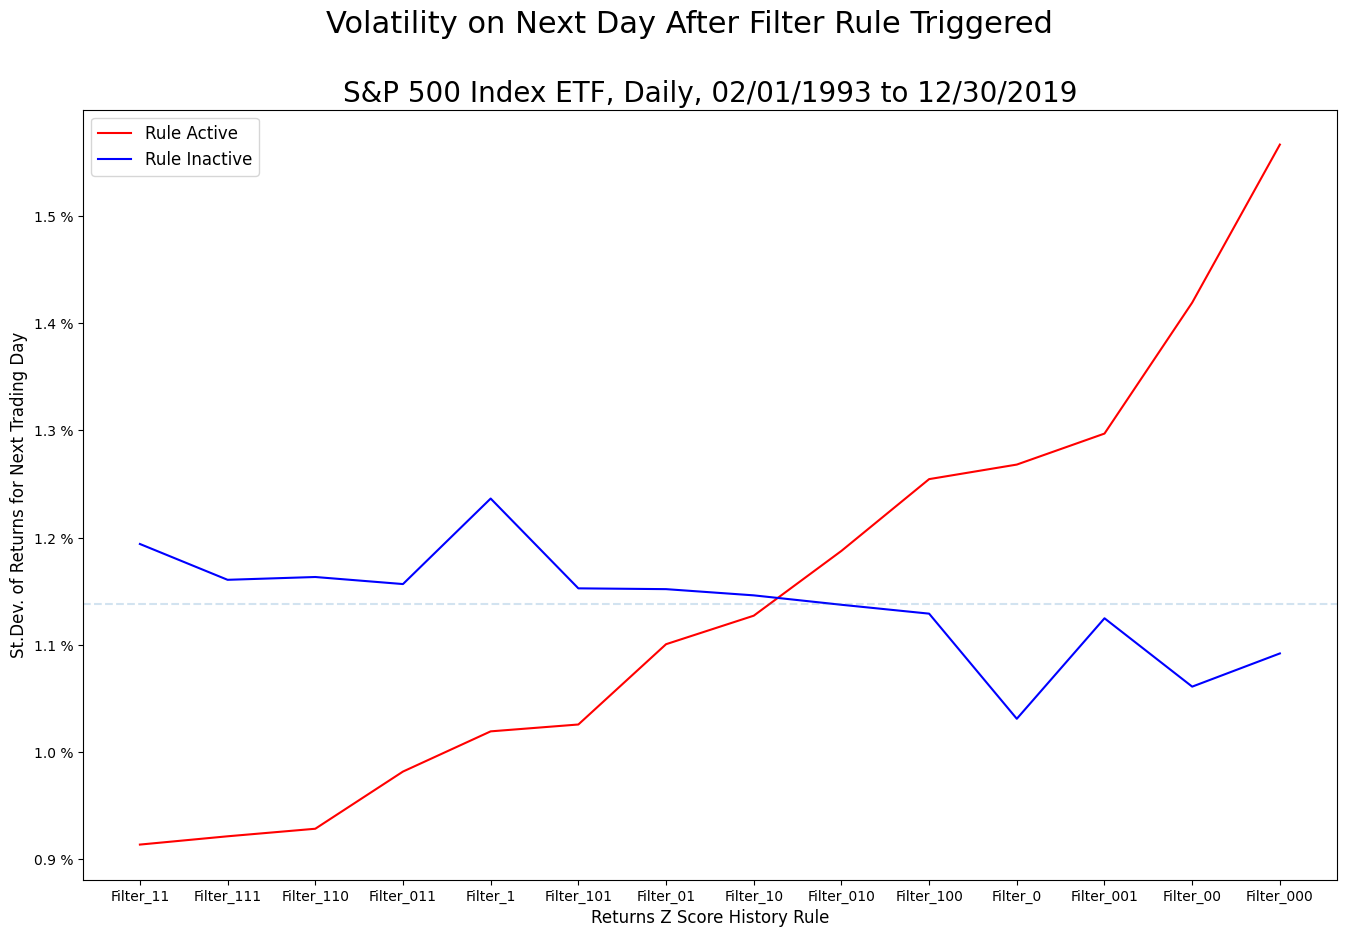

In [181]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
#plot.plot(x:=sorted([x for x in summary.index if '01' not in x and '10' not in x],key=lambda y:-len(y) if '0' in y else len(y)),y:=summary.loc[x,('Active',fn:='Vol.Ratio')],'-',color='red',label='Rule Active')
plot.plot(x:=summary.sort_values(('Active',fn:='Std.Dev.')).index,y:=summary.loc[x,('Active',fn)],'-',color='red',label='Rule Active')
plot.plot(x,y:=summary.loc[x,('Inactive',fn)],'-',color='blue',label='Rule Inactive')
plot.axhline(y.mean(),alpha=0.2,color='C0',linestyle='--')

if forder>3:
    plot.tick_params(axis='x',labelrotation=90)

if fn=='Std.Dev.':
    plot.yaxis.set_major_formatter(PercentLabels(1))
    plot.set_ylabel('St.Dev. of Returns for Next Trading Day',fontsize=12)

elif fn=='Vol.Ratio':
    plot.set_ylabel('Volatility Ratio (Experienced/Expected)',fontsize=12)
    plot.axhline(one,alpha=0.2,color='black',linestyle='-')

else:
    raise ValueError("Don't know how to label '{:s}' axis.".format(fn))

plot.set_xlabel('Returns Z Score History Rule',fontsize=12)
figure.suptitle(title:='Volatility on Next Day After Filter Rule Triggered',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)
plot.legend(fontsize=12)
figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

17:57:56 Fitting GJR-GARCH model with filter rules...
17:57:56
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.002
Mean Model:                                  AR-X   Adj. R-squared:                  0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8747.51
Distribution:      Generalized Error Distribution   AIC:                           17521.0
Method:                        Maximum Likelihood   BIC:                           17609.7
                                                    No. Observations:                 6769
Date:                            Wed, Mar 26 2025   Df Residuals:                     6760
Time:                                    17:57:56   Df Model:                            9
                                   Mean Model                                  
                  coef    std err     

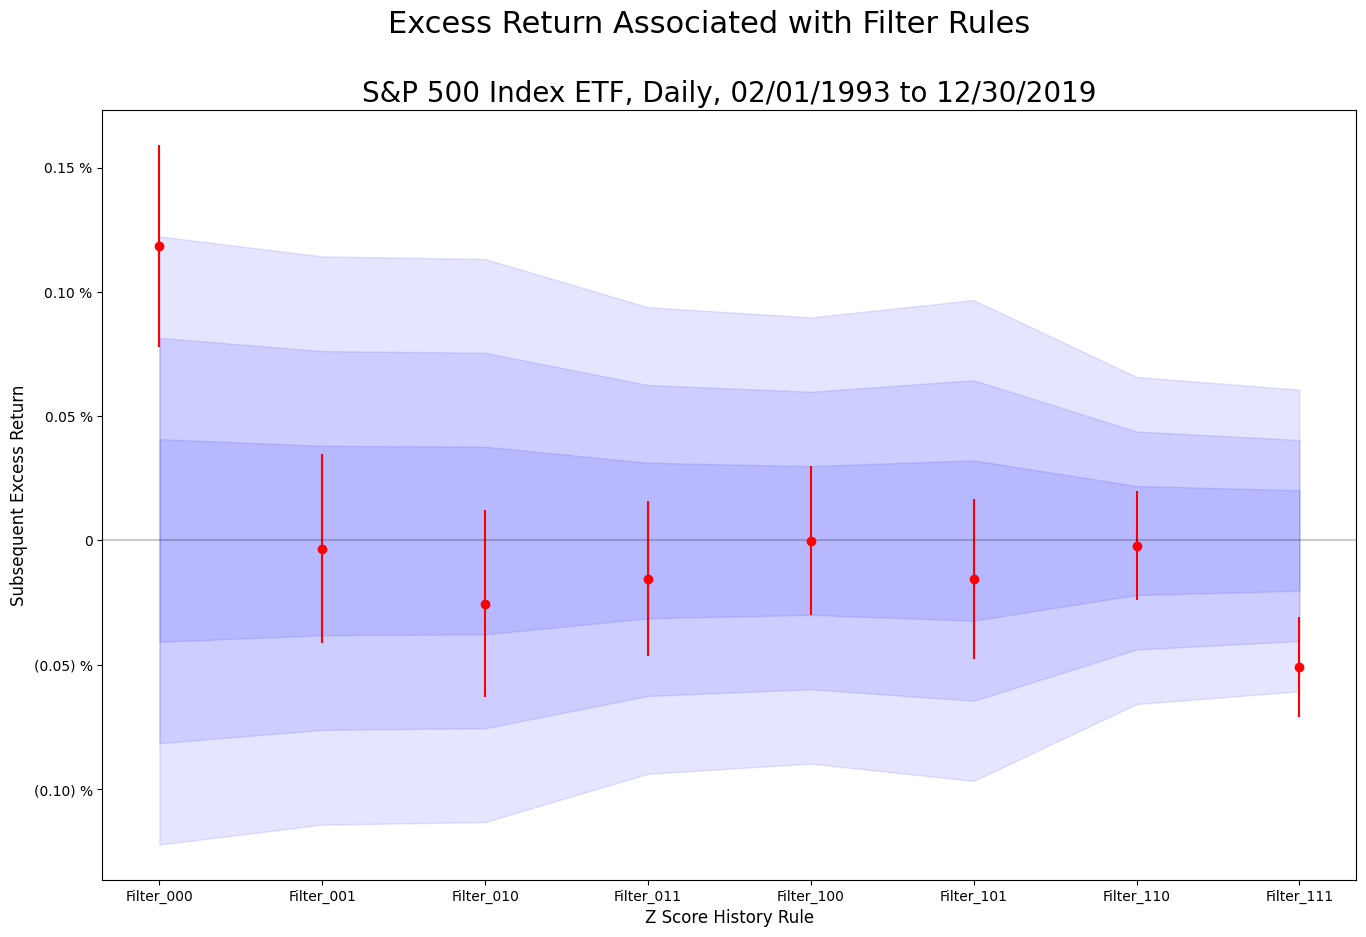

In [182]:
nprint("Fitting GJR-GARCH model with filter rules...")
model=ARX((design:=data.dropna())['Return'],design[fcols:=design.columns[design.columns.str.contains('Filter')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
coefficients=pd.DataFrame([fit.params[fcols],fit.std_err[fcols]]).T

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=coefficients.index,y:=coefficients['params'],ye:=coefficients['std_err'],fmt='o',color='red')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel('Subsequent Excess Return',fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel('Z Score History Rule',fontsize=12)
figure.suptitle(title:='Excess Return Associated with Filter Rules',fontsize=22)
plot.set_title(subtitle:='{:s}, Daily, {:s} to {:s}'.format(sname,data.index[0].strftime("%m/%d/%Y"),data.index[-1].strftime("%m/%d/%Y")),fontsize=20)

for s in range(1,4):
    plot.fill_between(x,-s*ye,y2=s*ye,alpha=0.1,color='blue')

if forder>3:
    plot.tick_params(axis='x',labelrotation=90)

figure.savefig(filename:=(filepath:='/content/drive/MyDrive/')+title+'.png',dpi=300,bbox_inches='tight')
nprint("Saved figure to '{:s}'.".format(filename))

### Fit a Conditional Model to (Filter_000 | Filter_111)

In [185]:
# make combination variables
data[fn:='Filter_000|111']=(data['Filter_000'].astype(bool)|data['Filter_111'].astype(bool)).astype(float)*data['Return'].shift()
nprint("Created combination %s." % fn)

nprint("Fitting a fusion autoregression...")
model=ARX((design:=data.dropna())['Return'],design[design.columns[design.columns.str.contains('\|')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return',fn]].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return',fn]].replace(zero,np.nan).dropna().shape[0]-three)))

17:59:47 Created combination Filter_000|111.
17:59:47 Fitting a fusion autoregression...
17:59:47
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.005
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8747.81
Distribution:      Generalized Error Distribution   AIC:                           17507.6
Method:                        Maximum Likelihood   BIC:                           17548.5
                                                    No. Observations:                 6769
Date:                            Wed, Mar 26 2025   Df Residuals:                     6767
Time:                                    17:59:47   Df Model:                            2
                                   Mean Model                                   
  

### Formulas for Article

$$
\alpha_t=\mathbb{E}[r_t|\mathcal{I}_s]:s<t
$$

$$
\alpha_t=f(\mathcal{I}_s)
$$

$$
f(\mathcal{I}_s)=\mu+\varphi r_{t-1}+\dots
$$

$$
\lim_{t\rightarrow\infty}\mathbb{E}[\alpha_t]=\mathbb{E}[r_t]
$$

$$
\overline{\{r_s : s<t\}}
$$

$$
\begin{align}
\alpha_t&=\mu+\varphi r_{t-1}\\
r_t&=\alpha_t+\sigma_t\varepsilon_t\\
\sigma_t^2&=C+B\sigma_{t-1}^2+Dr_{t-1}^2\mathbb{I}[r_{t-1}<0]\\
\varepsilon_t&\sim\mathop{\mathrm{GED}}(\kappa)\\
z_t&=\frac{r_t-\alpha_t}{\sigma_t}
\end{align}
$$

$$
\alpha_t=\mu+\chi r_{t-1}\times\left(\mathtt{Filter\_000}_{t-1}+\mathtt{Filter\_111_{t-1}}\right)
$$

### Fit a Hybrid using Both $AR(1)$ _and_ `Filter_000|111` in the Mean Model
This has residual covariance between AR(1) and the filter variable, so not 100% reliable.

In [136]:
nprint("Fitting a hybrid autoregression...")
model=ARX((design:=data.dropna())['Return'],design[fn],lags=1)
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (-data[['Return',fn]].replace(zero,np.nan).dropna().corr().iloc[0,1]*hundred,hundred/np.sqrt(data[['Return',fn]].replace(zero,np.nan).dropna().shape[0]-three)))

17:31:52 Fitting a hybrid autoregression...
17:31:52 Created combination Filter_000|111.
17:31:52
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.006
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8745.37
Distribution:      Generalized Error Distribution   AIC:                           17504.7
Method:                        Maximum Likelihood   BIC:                           17552.5
                                                    No. Observations:                 6768
Date:                            Wed, Mar 26 2025   Df Residuals:                     6765
Time:                                    17:31:52   Df Model:                            3
                                    Mean Model                                   
 

### Make a Model that Includes 1 Day, 2 Day and 3 Day Effects, Orthogonally

In [190]:
data[fn:='Filter_001|110']=(data['Filter_001'].astype(bool)|data['Filter_110'].astype(bool)).astype(float)*data['Return'].shift()
nprint("Created combination %s which is a two day streak that's not part of a three day streak." % fn)

data[fn:='Filter_011|010|100|101']=(data['Filter_011'].astype(bool)|data['Filter_010'].astype(bool)|data['Filter_100'].astype(bool)|data['Filter_101'].astype(bool)).astype(float)*data['Return'].shift()
nprint("Created combination %s which is a one day streak that's not part of a two or three day streak." % fn)

nprint("Fitting a fusion autoregression...")
model=ARX((design:=data.dropna())['Return'],design[design.columns[design.columns.str.contains('\|')]])
model.volatility=GARCH2(0,1,1)
model.distribution=GeneralizedError2()
fit=model.fit(update_freq=0,disp='off')
nprint(fit.summary(),sep='\n')
nprint("In-sample IC is (%.2f +/- %.2f) %%" % (hundred*fit.rsquared**half,hundred/np.sqrt(data[['Return',fn]].replace(zero,np.nan).dropna().shape[0]-three)))

18:48:44 Created combination Filter_001|110 which is a two day streak that's not part of a three day streak.
18:48:44 Created combination Filter_011|010|100|101 which is a one day streak that's not part of a two or three day streak.
18:48:44 Fitting a fusion autoregression...
18:48:44
                              AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                       0.006
Mean Model:                                  AR-X   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8746.79
Distribution:      Generalized Error Distribution   AIC:                           17509.6
Method:                        Maximum Likelihood   BIC:                           17564.1
                                                    No. Observations:                 6769
Date:                            Wed, Mar 26 2025   Df Residuals:            